__NOTE:__ The repo: https://github.com/AniTho/Computer_Vision_DL have some examples related to computer vision. It also have an autoencoder implemented. So here the focus would be mainly to find flaw in autoencoder (architecture slightly modified but it holds true for previous case) and motivate using variational autoencoder

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchsummary import summary
import wandb

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Helper Functions

In [2]:
def save_checkpoint(model, save_path):
    torch.save(model.state_dict(), save_path)
    
def load_checkpoint(model, save_path):
    model.load_state_dict(torch.load(save_path))
    return model

def visualization(dataloader, model, title, clear = True):
    model.eval()
    encoder = model.encoder
    sigmoid = nn.Sigmoid()
    num_examples = {i:10 for i in range(10)}
    fig_1, axes_1 = plt.subplots(nrows = 10, ncols = 10, figsize = (10,10))
    fig_2, axes_2 = plt.subplots(nrows = 10, ncols = 10, figsize = (10,10))
    embed = []
    labels = []
    i = 0
    with torch.no_grad():
        pbar = tqdm(dataloader, total = len(dataloader), leave = False)
        for imgs, lbls in pbar:
            imgs, lbls = imgs.to(device), lbls.to(device)
            imgs_inp = imgs.view(-1, 1, 28, 28)
            embeddings = encoder(imgs_inp)
            out = sigmoid(model(imgs))
            out = out.view(len(out), 1, 28, 28)
            embeddings = embeddings.view(len(out), -1)
            embed.extend(embeddings.cpu().detach().numpy().tolist())
            labels.extend(lbls.cpu().detach().numpy().tolist())
            for n in num_examples.keys():
                if num_examples[n] <= 0:
                    continue
                idxs = torch.where(lbls == n)[0][:num_examples[n]]
                num_examples[n] -= len(idxs)
                for idx in idxs:
                    idx = idx.item()
                    img = imgs[idx].detach().cpu().numpy()[0]
                    gen = out[idx].detach().cpu().numpy()[0]
                    axes_1[i//10, i%10].imshow(img, cmap = 'gray')
                    axes_1[i//10, i%10].axis('off')
                    axes_2[i//10, i%10].imshow(gen, cmap = 'gray')
                    axes_2[i//10, i%10].axis('off')
                    i+=1

    fig_3, axes = plt.subplots()
    embed = np.array(embed)
    labels = np.array(labels)
    color = plt.get_cmap('Spectral', 10)
    scatter_plot = axes.scatter(embed[:,0], embed[:,1], c = labels, cmap = color)
    plt.colorbar(scatter_plot, drawedges = True, ax = axes)
    wandb.log({f"{title}_original": fig_1, f"{title}_regenerated":fig_2, f"{title}_visualization": wandb.Image(fig_3)})
    if clear:
        fig_1.clear()
        plt.close(fig_1)
        fig_2.clear()
        plt.close(fig_2)
        fig_3.clear()
        plt.close(fig_3)

# Hyperparameters

In [3]:
batch_size = 64
input_vector_channel = 1
# Setting experiment
wandb.init(dir = 'logs/', project='GAN Projects', name="CNN based autoencoder")
num_filters = [32, 64, 128]
latent_dim = 2
filter_size = 3
strides = [2, 2, 2]
learning_rate = 1e-03
num_epochs = 25
criterion = nn.BCEWithLogitsLoss()
save_path = './saved_models/vanilla_cnn.pt'

wandb.config = {
    'batch_size': batch_size,
    'num_filters': num_filters,
    'latent_dim': latent_dim,
    'filter_size': filter_size,
    'strides': strides,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'initializer': 'glorot_uniform',
    'loss': 'bce_logits'
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aniketthomas. Use `wandb login --relogin` to force relogin


# Loading and preprocessing data

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: 1.0 - x)]) # Invert Color
fmnist_train = datasets.FashionMNIST('data/', train = True, transform=transform, download=True)
fmnist_val = datasets.FashionMNIST('data/', train=False, transform=transform, download=True)
trainloader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
validloader = DataLoader(fmnist_val, batch_size=batch_size, num_workers=8, pin_memory=True)

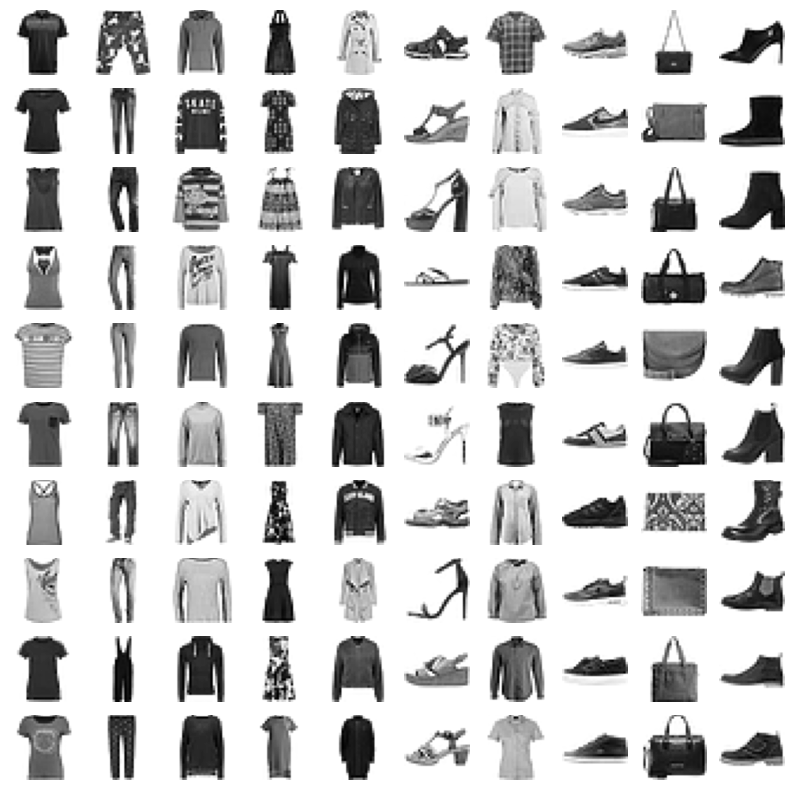

In [5]:
# Visualizing Data
train_images, train_labels = 1.0 - fmnist_train.data, fmnist_train.targets
unique_classes = np.unique(train_labels)
rows, cols = 10, len(unique_classes)
fig, axes = plt.subplots(rows, cols, figsize = (10,10))
i = 0
for _class in unique_classes:
    label_idx = np.where(train_labels == _class)[0]
    random_per_class = label_idx[np.random.choice(label_idx.shape[0], 10, replace = False)]
    for idx in random_per_class:
        img = train_images[idx]
        axes[i%10, i//10].imshow(img, cmap = 'gray')
        axes[i%10, i//10].axis('off')
        i+=1

# Autoencoder

In [6]:
class CNNAutoEncoder(nn.Module):
    def __init__(self, input_vector_channel, num_filters, latent_dim, strides):
        super(CNNAutoEncoder, self).__init__()

        enc_list = []
        dec_list = []
        self.inp_dim = input_vector_channel[0]
        all_units = input_vector_channel + num_filters
        for i in range(len(all_units) - 1):
            temp = [nn.Conv2d(all_units[i], all_units[i+1], 3, strides[i], padding=1),
                    nn.ReLU(inplace = True)]
            enc_list.extend(temp)

        # Calculated from hand or can run torchsummary once to check dimensions
        self.shape_before_flatten = np.array([128, 4, 4])
        enc_list.append(nn.Flatten())
        enc_list.append(nn.Linear(np.prod(self.shape_before_flatten), latent_dim))

        self.encoder = nn.Sequential(*enc_list)

        self.bottleneck = nn.Linear(latent_dim, np.prod(self.shape_before_flatten))

        dec_list.extend([nn.ConvTranspose2d(all_units[-1], all_units[-1], 3, 2, padding=1),
                         nn.ReLU(inplace = True)])
        
        for i in range(len(all_units) - 1, 1, -1):
            temp = [nn.ConvTranspose2d(all_units[i], all_units[i-1], 3, strides[i-1], padding = 1, output_padding=1),
                    nn.ReLU(inplace = True)]
            dec_list.extend(temp)
        dec_list.extend([nn.ConvTranspose2d(all_units[i-1], all_units[i-2], 3, 1, padding = 1)])
        self.decoder = nn.Sequential(*dec_list)

        # Initialize weights
        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)
        self.bottleneck.apply(self.init_weights)

    def init_weights(self, layer):
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.0)

    def forward(self, x):
        out = self.encoder(x)
        out = self.bottleneck(out)
        out = out.view(-1, *self.shape_before_flatten)
        out = self.decoder(out)
        return out

In [7]:
cnn_autoencoder = CNNAutoEncoder([input_vector_channel], num_filters, latent_dim, strides)
summary(cnn_autoencoder, (1, 28, 28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2]                   --
|    └─Conv2d: 2-1                       [-1, 32, 14, 14]          320
|    └─ReLU: 2-2                         [-1, 32, 14, 14]          --
|    └─Conv2d: 2-3                       [-1, 64, 7, 7]            18,496
|    └─ReLU: 2-4                         [-1, 64, 7, 7]            --
|    └─Conv2d: 2-5                       [-1, 128, 4, 4]           73,856
|    └─ReLU: 2-6                         [-1, 128, 4, 4]           --
|    └─Flatten: 2-7                      [-1, 2048]                --
|    └─Linear: 2-8                       [-1, 2]                   4,098
├─Linear: 1-2                            [-1, 2048]                6,144
├─Sequential: 1-3                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-9              [-1, 128, 7, 7]           147,584
|    └─ReLU: 2-10                        [-1, 128, 7, 7]         

In [8]:
visualization(trainloader, cnn_autoencoder, "Pre_Train", clear = True)
visualization(validloader, cnn_autoencoder, "Pre_valid", clear = True);

# Training Autoencoder



In [9]:
def train_batch(imgs, model, criterion, optimizer, scaler, valid = False):
    optimizer.zero_grad()
    imgs, model = imgs.to(device, non_blocking = True), model.to(device)
    imgs = imgs.view(-1, 1, 28, 28)
    with torch.cuda.amp.autocast():
        out = model(imgs)
        batch_loss = criterion(out, imgs)
    if not valid:
        scaler.scale(batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()
    return batch_loss.item()

def train(trainloader, validloader, model, criterion, optimizer, num_epochs, load_check = False, best_valid_metric = 0.0, 
          save_path = './saved_models/checkpoint.pt'):    
    # Load From checkpoint
    if load_check:
        model = load_checkpoint(model, save_path)

    scaler = torch.cuda.amp.GradScaler()
    train_losses, valid_losses = [], []
    for epoch in range(num_epochs+1):
        batch_loss = 0.0
        model.train()
        pbar = tqdm(trainloader, total = len(trainloader), leave = False)
        for imgs, _ in pbar:
            imgs = imgs.to(torch.float32)
            current_batch_loss = train_batch(imgs, model, criterion, optimizer, scaler)
            batch_loss += current_batch_loss
            pbar.set_postfix(train_loss = current_batch_loss)

        epoch_train_loss = batch_loss / len(trainloader)
        train_losses.append(epoch_train_loss)

        # Calculating for Valid data
        batch_loss = 0.0
        model.eval()
        pbar = tqdm(validloader, total = len(validloader), leave = False)
        with torch.no_grad():
            for imgs, _ in pbar:
                imgs = imgs.to(torch.float32)
                current_batch_loss = train_batch(imgs, model, criterion, optimizer, scaler, valid = True)
                batch_loss += current_batch_loss
                pbar.set_postfix(valid_loss = current_batch_loss)

        epoch_valid_loss = batch_loss / len(validloader)
        valid_losses.append(epoch_valid_loss)
        
        # Checkpoint
        if epoch_valid_loss < best_valid_metric:
            print('#### Saving ####')
            save_checkpoint(model, save_path)
            best_valid_metric = epoch_valid_loss
            
        wandb.log({'epoch':epoch ,'train_loss': epoch_train_loss, 'valid_loss': epoch_valid_loss})
        visualization(trainloader, cnn_autoencoder, "Epoch_train")
        visualization(validloader, cnn_autoencoder, "Epoch_valid")
        print(f"{'*'*10} EPOCH {epoch:2}/{num_epochs} {'*'*10}")
        print(f'''{"#"*33}
Train Loss: {epoch_train_loss:5.3f}
Valid Loss: {epoch_valid_loss:5.3f}
{"#"*33}''')
    return train_losses, valid_losses

In [ ]:
optimizer = optim.Adam(cnn_autoencoder.parameters(), lr = learning_rate)
train_losses, valid_losses = train(trainloader, validloader, cnn_autoencoder, criterion, optimizer, num_epochs, 
                                   best_valid_metric=999999, save_path=save_path)

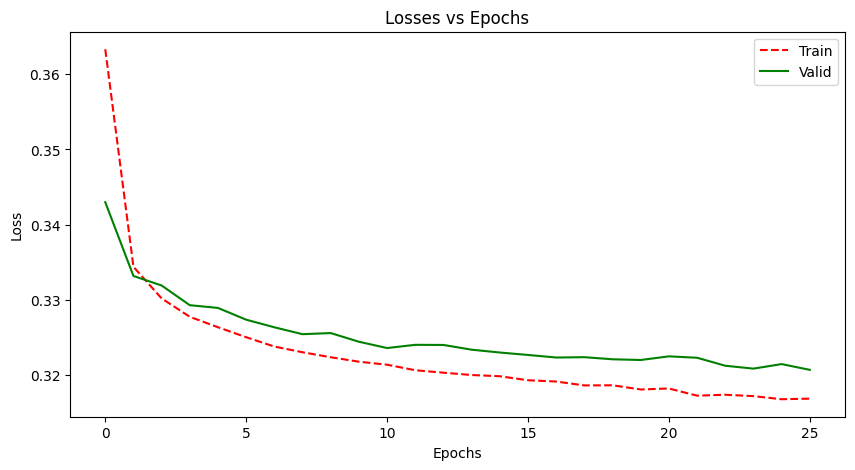

In [11]:
plt.figure(figsize = (10,5))
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend()
plt.show();

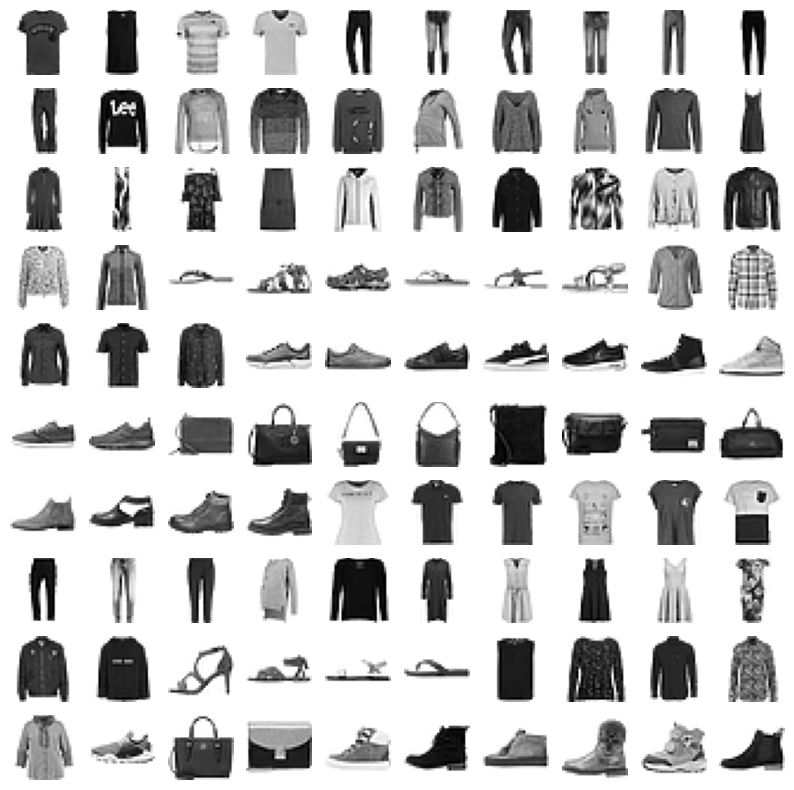

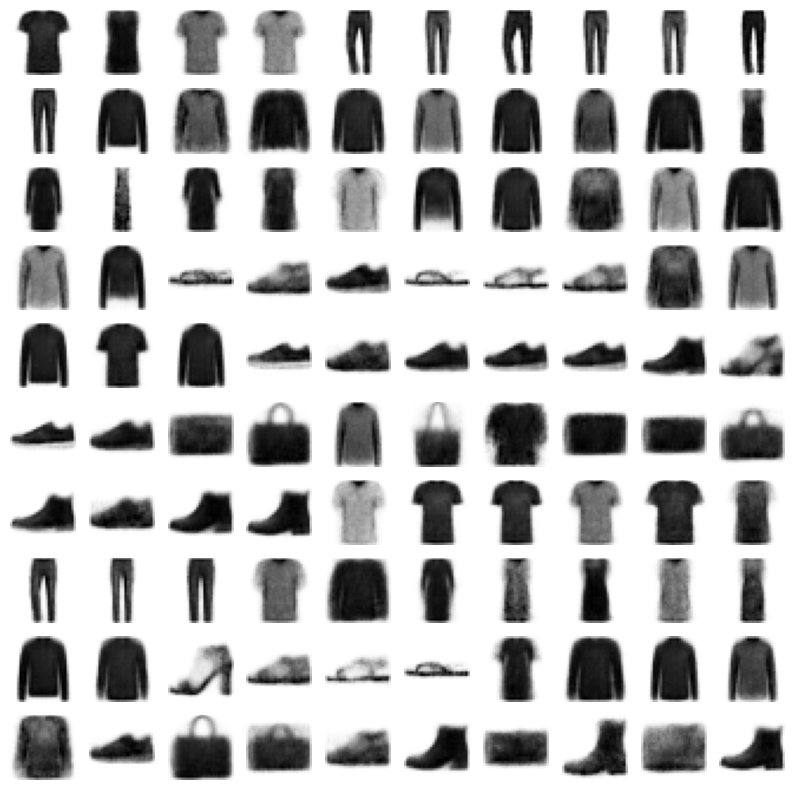

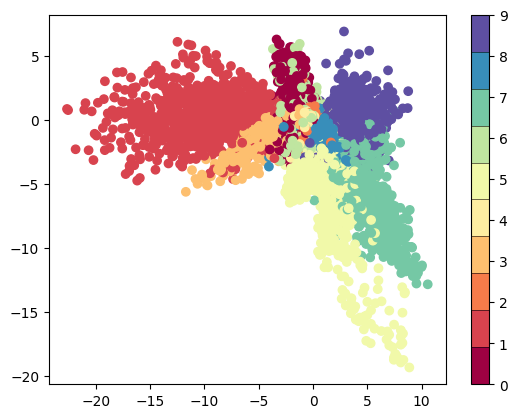

In [12]:
cnn_autoencoder = load_checkpoint(cnn_autoencoder, save_path)
visualization(trainloader, cnn_autoencoder, "Post_train", clear = True)
visualization(validloader, cnn_autoencoder, "Post_valid", clear = False);

Autoencoder generated good results and is able to cluster the data without any labels "unsupervised technique"

# Sampling and results 

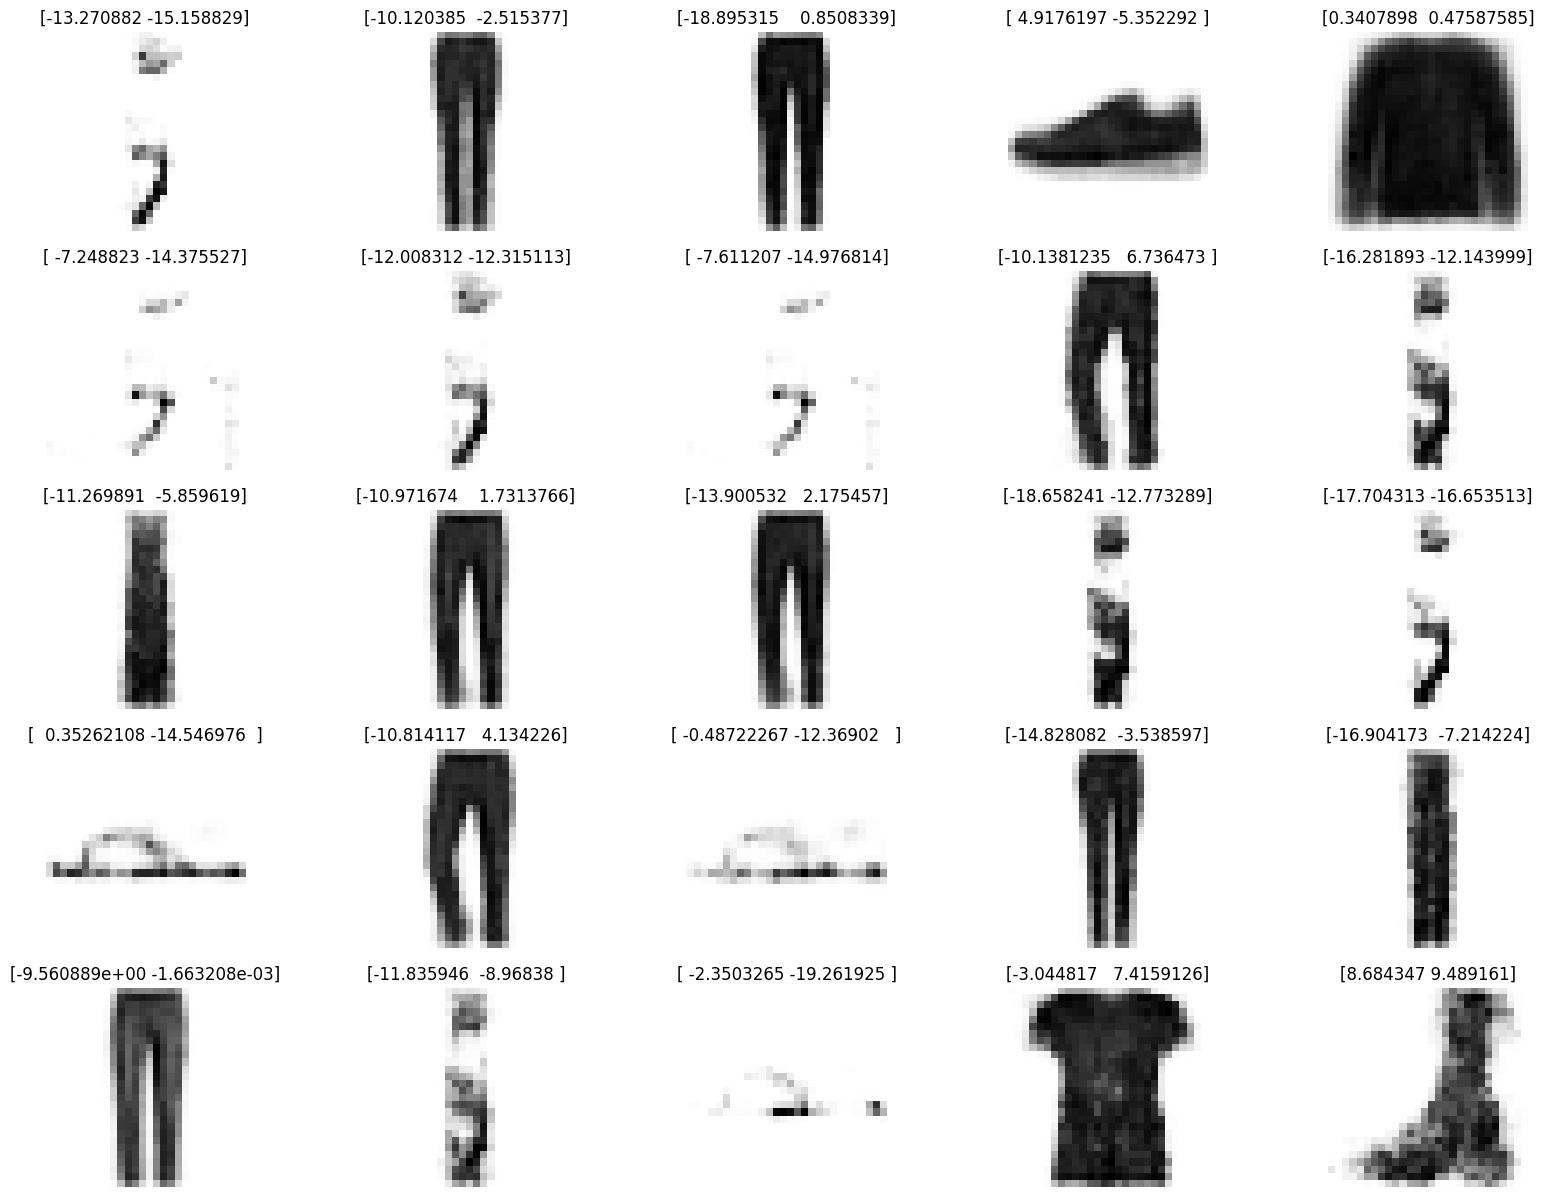

In [23]:
with torch.no_grad():
    cnn_autoencoder.eval()
    min, max = -20, 10

    # Setting for plots
    num_images = 25
    nrows = 5
    ncols = num_images // nrows + (num_images % nrows > 0)

    # Sample and Generation
    samples = (max - min)*torch.rand((num_images, 2)) + min
    samples = samples.to(device)
    sigmoid = nn.Sigmoid()
    out = cnn_autoencoder.bottleneck(samples)
    out = out.view(-1, *[128, 4, 4])
    out_images = cnn_autoencoder.decoder(out)
    out_images = sigmoid(out_images)
    plt.figure(figsize=(20, 15))
    for i in range(num_images):
        img = out_images[i][0] # Get first channel
        img = img.detach().cpu().numpy()
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img, cmap = 'gray')
        plt.title(f'{samples[i].detach().cpu().numpy()}')
        plt.axis('off')

# Flaws

__NOTE:__ As it is pretty evident that some of the images represent images from dataset itself but some are just arbitrary random image without any significance of dataset. 
- As it can be notices in validation projection plot that most of the region is empty so if the sampling is done from that region then the image generated is arbitrary (though it is well within the range where all images are projected), this can be very huge space if the dimensions are more and thus only a very small region of the total projected area can only be useful to generate images.
- Also notice that some region of images are pretty small and some are pretty large so this can be a bit problematic

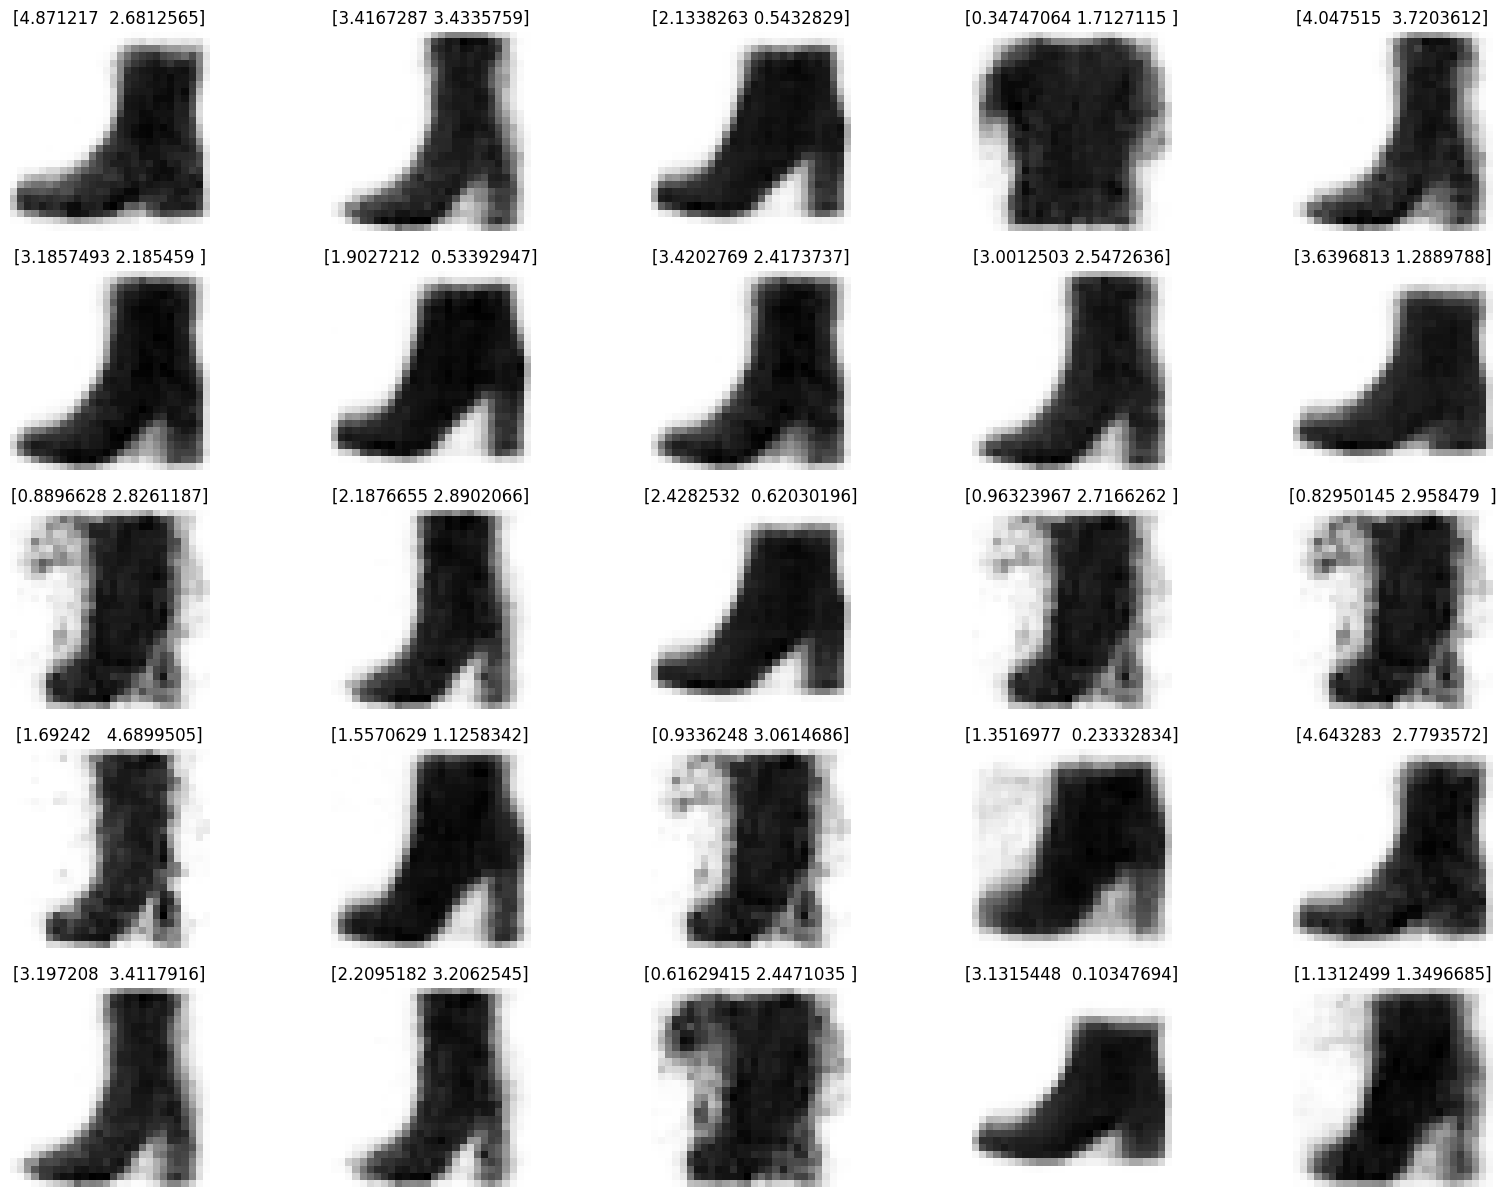

In [24]:
with torch.no_grad():
    cnn_autoencoder.eval()
    min, max = 0, 5

    # Setting for plots
    num_images = 25
    nrows = 5
    ncols = num_images // nrows + (num_images % nrows > 0)

    # Sample and Generation
    samples = (max - min)*torch.rand((num_images, 2)) + min
    samples = samples.to(device)
    sigmoid = nn.Sigmoid()
    out = cnn_autoencoder.bottleneck(samples)
    out = out.view(-1, *[128, 4, 4])
    out_images = cnn_autoencoder.decoder(out)
    out_images = sigmoid(out_images)
    plt.figure(figsize=(20, 15))
    for i in range(num_images):
        img = out_images[i][0] # Get first channel
        img = img.detach().cpu().numpy()
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img, cmap = 'gray')
        plt.title(f'{samples[i].detach().cpu().numpy()}')
        plt.axis('off')

- Also note by above that generation of a particular image is a region is continuous, that means if 1.13 generates a boot doesn't mean that 1 will also generate a boot

And this is what motivated variational autoencoder which helps to counter these three problem by mapping the image to a distribution (normal) with mean $\mu$ and std dev: $\sigma$ which will be the cluster of our data from which then the sampling can be done to get desired results